# Pax Workshop
## Lab 6: Pax End-to-end Tutorial



Goal: In this lab, you will put together all that you have learned so far. You will be building a Translator using a Transformer Encoder/Decoder Architecture using the Pax framework.

# Intro

This notebook is a tutorial on a few key ML concepts, including:

* Transformers
* JAX (which is so cool)
* Pax

Below we will be building a Translator using a Transformer Encoder/Decoder Architecture. The model is built using the Pax framework which I find pretty compelling for building and maintaining complex models and their associated configurations.

JAX really makes development and debugging a lot easier. Being able to inspect all your arrays easily with simple `print()` statements make a tremendous difference. Using methods like `jax.pmap()`–which you will learn about below–makes running on multiple TPU's so easy.

Before we get started, a note on how to use this notebook. I found that I learned better by starting with a blank notebook on a new tab and then coping 1 cell at a time, running, inspecting the variables, running JAX NumPy on it to understand the logic, etc. With this methodology, I got to understand both JAX and NumPy better, how to create a padding mask (even though Pax has helper methods), and many lower level details of working with these Frameworks.

This notebook, assumes you have already done the starter notebook on JAX and Pax layers. We do not go too deep into the layer design here, but instead show how to build test and combine them to train a model.

# Getting Started

Import important base libraries.

In [ ]:
!pip3 install git+https://github.com/deepmind/einshape

In [ ]:
# This notebook demonstrates key concepts in Pax

import dataclasses
import os
import tempfile
from typing import Any, Optional, Union

import chex
import jax
import jax.numpy as jnp
import numpy as np
from einshape import jax_einshape as einshape
from praxis import base_hyperparams
from praxis import base_layer
from praxis import py_utils
from praxis import layers
from praxis import pax_fiddle
from praxis import pytypes

NestedMap = py_utils.NestedMap
WeightInit = base_layer.WeightInit
WeightHParams = base_layer.WeightHParams
InstantiableParams = py_utils.InstantiableParams
JTensor = pytypes.JTensor
NpTensor = pytypes.NpTensor
WeightedScalars = pytypes.WeightedScalars
instantiate = base_hyperparams.instantiate

# Standard prng key names
PARAMS = base_layer.PARAMS
RANDOM = base_layer.RANDOM

key = jax.random.PRNGKey(seed=1234)

# Multi-Headed Attention

*Multi-headed attention* is one of the key concepts behind the Transformer Architecture. The paper from Google ["Attention is all you need"](https://arxiv.org/pdf/1706.03762.pdf) is a really good starting point to learn about it.

Before we get into multi-headed attention, let's first introduce the
single-headed scaled dot-product attention layer. Multi-headed attention is largely an extension to single-headed attention.

## Scaled Dot-Product Attention

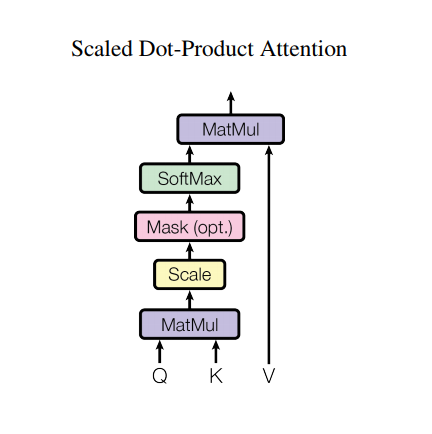

The *attention* function used by the transformer takes three inputs: $Q$ (query), $K$ (key), $V$ (value). The equation used to calculate the attention weights is:

\begin{align}
Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V
\end{align}

(Ignore the slight abuse of notation as far as the running index $k$ goes: $d_k$ is meant to represent the query and key dimensionality.)

The dot-product attention is scaled by a factor of square root of the depth. This is done because, for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax.

For example, consider that $Q$ and $K$ have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of dk. So the square root of dk is used for scaling, so you get a consistent variance regardless of the value of dk. If the variance is too low the output may be too flat to optimize effectively. If the variance is too high the softmax may saturate at initialization making it difficult to learn.

The input mask is assumed to contain a large negative value where the inputs need to be masked. This is done because the mask is summed with the scaled matrix multiplication of $Q$ and $K$ and is applied immediately before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output. We use Pax helpers to accomplish this, but I have a quick detour on masks, right after this class to describe the different type of masks we will need to build our Translation model.



In [ ]:
class MultiHeadedAttention(base_layer.BaseLayer):

  """Transformer multiheaded attention layer.

  Attributes:
    num_head: Number of heads for MultiHeadedAttention layer.
    input_dim: Input dimension of attention layer.
    atten_dropout_prob: Attention dropout probability.
  """
  num_head: int = 0
  input_dim: int = 0
  atten_dropout_prob: float = 0.0

  def setup(self) -> None:
    if self.input_dim % self.num_head != 0:
      raise ValueError(f'{self.input_dim=} must be a multiple of '
                       f'{self.num_head=}')
    self.depth = self.input_dim // self.num_head

    # Create the linear layers.
    # Each of the below `w` matrices is `concat(w_i for i in range(num_head))`.
    self.create_child(
        'wq',
        pax_fiddle.Config(
            layers.Linear, input_dims=self.input_dim,
            output_dims=self.input_dim))
    self.create_child(
        'wk',
        pax_fiddle.Config(
            layers.Linear, input_dims=self.input_dim,
            output_dims=self.input_dim))
    self.create_child(
        'wv',
        pax_fiddle.Config(
            layers.Linear, input_dims=self.input_dim,
            output_dims=self.input_dim))
    self.create_child(
        'dense',
        pax_fiddle.Config(
            layers.Linear, input_dims=self.input_dim,
            output_dims=self.input_dim))

  @staticmethod
  def dot_attention(
      query: JTensor,
      key: JTensor,
      value: JTensor,
      atten_mask: Optional[JTensor] = None) -> tuple:
    """Calculate the attention weights.

    q, k, v must have matching leading dimensions (in this case batch size and
    num_heads). k, v must have matching penultimate dimension, i.e.: seq_len_k =
    seq_len_v.

    The mask has different shapes depending on its type (padding or look ahead)
    but it must be broadcastable for addition.

    Args: Using the notation b = batch_size, n = num_heads, s = sequence length
      of key and value, t = sequence length of query, h = dimension of heads,
      the arguments of the shape must be as follows:
          q: query shape == [b, n, t, h]
          k: key shape   == [b, n, s, h]
          v: value shape == [b, n, s, h]
          mask: Float tensor with shape broadcastable to [..., t, s]. Defaults
          to None.

    Returns:
      output with shape [b, n, t, h]
      attention_weights with shape [b, n, t, s]
    """
    # confirm we have the right input shapes
    b, n, s, h = key.shape
    t = query.shape[2]
    base_layer.assert_has_shape(value, [b, n, s, h])
    base_layer.assert_has_shape(query, [b, n, t, h])

    logits = jnp.einsum('BNTH,BNSH->BNTS', query, key)
    base_layer.assert_has_shape(logits, [b, n, t, s])

    scaled_attention_logits = logits / jnp.sqrt(h)

    # add the mask to the scaled tensor.
    if atten_mask is not None:
      # If only padding bias is supplied, then atten_mask can be [B, 1, 1, S]
      # since each target token is prohibited from attending to the same set of
      # source tokens. In this case tiling is inefficient and unnecessary.
      # If there is no padding mask, and only causal mask then the shape can be
      # [1, 1, T, S]
      chex.assert_shape(atten_mask, [{1, b}, 1, {1, t}, s])
      scaled_attention_logits += atten_mask

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = jax.nn.softmax(scaled_attention_logits, axis=-1)
    output = jnp.einsum('BNTS,BNSH->BNTH', attention_weights, value)
    base_layer.assert_has_shape(output, [b, n, t, h])

    return output, attention_weights

  def split_heads(self, x: JTensor) -> JTensor:
    """Split and transpose a (b, l, hd) tensor into one with shape (b, h, l, d).


    Split the last dimension into (num_heads, depth), then transpose the inner
    two dimensions, returning a tensor with shape
        ((b)atch_size, num_(h)eads, seq_(l)en, (d)epth).
    """
    return einshape('bl(hd)->bhld', x, h=self.num_head)

  def __call__(self, query: JTensor, key: JTensor, value: JTensor,
               atten_mask: JTensor) -> tuple:
    """Compute multihead attention on the input query, key, and value.

    Args: Using the notation b = batch_size, s = sequence length of key and
      value, t = sequence length of query, d = dimension of key, query, value
      features, the arguments of the shape must be as follows:
          q: query shape == (b, t, d)
          k: key shape   == (b, s, d)
          v: value shape == (b, s, d)
          atten_mask: Float tensor with shape broadcastable to (..., t, s).
            Defaults to None.

    Returns:
      output attention with shape (b, t, d) - matching the query shape
      attention weight with shape (b, t, s)
    """    
    # Get dim sizes
    (b, s, d), (_, t, _) = key.shape, query.shape

    # Ensure that the input_tensor has an appropriate shape.
    base_layer.assert_has_shape(key, [b, s, self.input_dim])
    base_layer.assert_has_shape(value, [b, s, d])
    base_layer.assert_has_shape(query, [b, t, d])

    query = self.split_heads(self.wq(query))
    key = self.split_heads(self.wk(key))
    value = self.split_heads(self.wv(value))

    base_layer.assert_has_shape(query, [b, self.num_head, t, self.depth])

    scaled_attention, attention_weights = self.dot_attention(
        query, key, value, atten_mask)
    # Flip axes and concatenate the N separate heads back into a single vector
    # before applying the dense feed-forward model.
    concat_attention = einshape('bnth->bt(nh)', scaled_attention)
    base_layer.assert_has_shape(concat_attention, [b, t, d])

    output = self.dense(concat_attention)
    return output, attention_weights

The code above, which implements a full Pax layers, does quite a few things at once. Don't worry we will cover each shortly, but for now let's focus on the static class method called 'dot_attention'. And test it out on a few examples.

In [ ]:
def print_out(q: JTensor, k: JTensor, v: JTensor) -> None:
  out, attn = MultiHeadedAttention.dot_attention(q, k, v, None)
  print(f'Attention weights are: {attn}')
  print(f'Output is: {out}')

In [ ]:
# Note that the rows here are orthogonal to each other.
k = jnp.array([[[
    [10, 0, 0],
    [0, 10, 0],
    [0, 0, 10],
    [0, 0, 10],
]]])

v = jnp.array([[[
    [11, 0, 0],
    [12, 0, 0],
    [100, 5, 0],
    [1000, 6, 0],
]]])

# The first ([10, 0, 0]) and second ([0, 10, 0]) row of `query` align with the
# first and second `key` rows respectively, so the first and second `value`
# vectors are returned in order as the output. This equivalently means that the
# attention is focussed for those value's indices.
q = jnp.array([[[
    [10, 0, 0],
    [0, 10, 0],
]]])

In [ ]:
output, weight = MultiHeadedAttention.dot_attention(q, k, v)
print(f'output:\n{output}')
print(f'shape: {output.shape}')
print(f'weight:\n{weight}')

Our query consists of two vectors $[10, 0, 0]$ and $[0, 10, 0]$ respectively, which correspond to the first two rows of our key matrix. If we look at the attention weights calculated and multiply these with our value matrix, you can see that we are selecting the first 2 rows of the value matrix:

>   ```[11, 0, 0]```

>   ```[12, 0, 0]```


You will also notice that the matrix is 3-dimensional array / tensor. The dot-attention static method is designed to be used directly in the layer that takes as input a 3D tensor of shape `[batch_size, sequence_length, vector_dimension]`.

Also note in Pax/JAX we use ndarray and tensor (`JTensor`) interchangeably. `JTensor` is just a typedef to `jnp.ndarray`

**Interlude #1 - Pax layers**

Pax layers are a way you add structure to your code, and create new layers for yourself and hopefully for others to re-use. A layer typically represents a sub part of your network. As with any mature framework the Pax codebase implements a pletora of basic layers that you can combine into interesting ways to build the next breakthrough in AI, and who knows maybe one day approach AGI!

In this example, we are building a MultiHeadedAttention layer.

To build a basic functional layer you need to implement 3 code blocks

```
  class attributes to set with fiddle.
```
Every layer needs parameters to configure your model.
```
  def setup(self):
```
Creates the layer variables and/or sub-layers. `layer.create_child` and `layers.create_children` will be your friends for making complex networks.
```
  def __call__(....)
```
Implements the forward propagation step of your layer (mini network). In the `__call__()` step we implement the math behind our model.


**Interlude #2 - Back to MultiHeaded Attention**

Let's get back to our layer above. You will notice it does much more than the static class method called dot_attention(). Multi-head attention consists of four parts:

* The three inputs: $Q$ (query), $K$ (key), $V$ (value). 
* Linear layers for the inputs.
* Scaled dot-product attention.
* Final linear layer.

In Multi-headed attention, ($K$,$Q$,$V$) are passed through seperate linear (Dense) layers for each attention head. For simplicity/efficiency the code below implements this using a single dense layer with `num_head` times as many outputs. So, essentially each head has an attention dimension of `d_model // num_head`. The output is rearranged to a shape of `(batch, num_head, ...)` before applying the attention function. Formally, multi-head attention is defined as below in terms of scaled dot-product attention:

\begin{align}
MultiHeadAttention(Q, K, V) = Concat(head_1, ..., head_n) W^O
\end{align}

where

\begin{align}
head_i = Attention(QW_i^Q, KW_i^K, VW_i^V)
\end{align}

An appropriate mask must be used in the attention step. The attention output for each head is then concatenated (using `jnp.transpose`, and `jnp.reshape`) and put through a final Dense layer.


Instead of one single attention head, $Q$, $K$, and $V$ are split into multiple heads because it allows the model to jointly attend to information from different representation subspaces at different positions. After the split each head has a reduced dimensionality ($W_i^Q, W_i^K \in \mathbb{R}^{d_{model} \times d_k}$, $W_i^V \in \mathbb{R}^{d_{model} \times d_v}$ and $d_k = d_v = \frac{d_{model}}{num\_head}$) so the total computation cost is the same as a single head attention with full dimensionality.

**Homework #1 - jnp.einsum**

Einsum is your friend. Try it below on the $q$, $k$, $v$ matrices defined above. Also take a look at a short tutorial: https://ajcr.net/Basic-guide-to-einsum/, it is quite powerful/expressive.

In [ ]:
# type in your own einsum code to make sure you understand einsum

**Interlude #3 - Masking**

When working on TPUs you quickly learn about **padding**. When we send training data to the TPU, it really likes everything to be of the same length, but our data, more often than not, is of varied length. The solution to this is to pad our input sequences with 0's.

```
a = [1, 7, 9, 12, 3, 0, 0, 0]
```

But now if we just use this vector as input, we are confusing our model. Are the 0's data or not? This is where padding comes in. A *padding mask* will be used to represent which datapoints are real and which are padded. It ensures that the model does not treat padding as the input. The mask indicates where pad value 0 is present: it outputs a 1 at those locations, and a 0 otherwise.

So given our example vector above, the padding mask would look as follows

```
padding_a = [0, 0, 0, 0, 0, 1, 1, 1]
```


In [ ]:
def create_padding_mask(seq: NpTensor) -> NpTensor:
  seq = np.equal(seq, 0).astype(np.float32)
  return seq  # (batch_size, 1, 1, seq_len)

Let's test our padding mask:

In [ ]:
a = np.array([1, 7, 9, 10, 12, 7, 0, 0, 0, 0])
create_padding_mask(a)

Things get more interesting when we start building our Transformer translator. During training we have two inputs to our model: the source and the target sentence.

I'm skipping ahead a bit here. The transformer decoder is an auto-regressive model. During inference it predicts one word at a time and then uses those predictions and the source language sentence to predict the next word. Given this, during attention modeling we need to ignore future tokens in the target sentence. To do that, we create a `look_ahead_mask` that will be used during the attention calculation to mask future tokens at any given index.

In [ ]:
def create_look_ahead_mask(size: int) -> NpTensor:
  mask = np.ones([size, size])
  mask[np.tril_indices(size)] = 0.0
  return mask  # (seq_len, seq_len)

In [ ]:
create_look_ahead_mask(a.shape[0])

**Homework #2**

The code above used `np.tril_indices()`, a pretty cool function to get the lower triangular elements in a matrix. This does not exist in JAX numpy. How can you create a lower triangular matrix of 0's and upper triangular matrix of 1's in another way. (Hint: 1<2, 2<3, 3<4)

In [ ]:
# create a lower triangular matrix.

Now we have our 2 important masks, but we are not quite done yet. Notice we created a look-ahead mask for the complete sequence of our vector **a**. But the last four elements are not to be used. So we have to combined the upper triangular matrix of 1's with the padding mask we just learned about. The single line below in our final `create_masks()` function does this for us

```
np.maximum(dec_target_padding_mask, look_ahead_mask)
```

Pretty cool. One of the lessons of learning transformers, is also learning these cute tricks. Of course, we don't really need to go through all this trouble. Pax has nice helper methods for us to accomplish the same. It is good though to do some things yourself to build a deeper understanding of the modeling architecture.

In [ ]:
def create_masks(inp: NpTensor,
                 tar: NpTensor) -> tuple:
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)

  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)

  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tar.shape[-1])
  dec_target_padding_mask = create_padding_mask(tar)

  # np.maximum keep the band-part (upper triangular) section for the
  # parts of the sequence that has real data and uses a padding mask
  # for the rest. For example, for a target sequence with length=3 padded to
  # length=5:
  # 0 1 1 1 1
  # 0 0 1 1 1
  # 0 0 0 1 1
  # 0 0 0 1 1
  look_ahead_mask = np.maximum(dec_target_padding_mask, look_ahead_mask)

  return enc_padding_mask, look_ahead_mask, dec_padding_mask

In [ ]:
enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(a, a)
look_ahead_mask

# A 'special' FeedForward layer

A basic building block in the Transformer architecture is a 2-layer Fully Connected FeedForward layer with RELU activations in the hidden layer.

**Homework #3** - Make a drawing of this layer by inspecting the code below


.

.

.

.

.
.

Add your picture above in the text box.


In [ ]:
class TransformerFeedForwardLayer(base_layer.BaseLayer):
  """Transformer feedforward layer with residual connection and dropout.

  Attributes:
    input_dim: Depth of the input.
    hidden_dim: Hidden dimension of FFN.
    residual_dropout_prob: Residual dropout.
    relu_dropout_prob: FFN dropout.
  """
  input_dim: int = 0
  hidden_dim: int = 0
  residual_dropout_prob: float = 0.0
  relu_dropout_prob: float = 0.0

  def setup(self) -> None:
    self.create_child(
        'layer_norm',
        pax_fiddle.Config(
            layers.LayerNorm, dim=self.input_dim))

    # Create the first Feedforward layer, mapping to hidden dim.
    self.create_child(
        'ffn_layer1',
        pax_fiddle.Config(
            layers.FeedForward, input_dims=self.input_dim,
            output_dims=self.hidden_dim,
            activation_tpl=pax_fiddle.Config(layers.ReLU)))

    # Create RELU dropout layer.
    self.create_child(
        'relu_dropout',
        pax_fiddle.Config(
            layers.Dropout, keep_prob=1.0 - self.relu_dropout_prob))

    # Create the second Feedforward layer, mapping from hidden dim.
    self.create_child(
        'ffn_layer2',
        pax_fiddle.Config(
            layers.FeedForward, input_dims=self.hidden_dim,
            output_dims=self.input_dim,
            activation_tpl=pax_fiddle.Config(layers.Identity)))

    # Create residual dropout layer.
    self.create_child(
        'residual_dropout',
        pax_fiddle.Config(
            layers.Dropout, keep_prob=1.0 - self.residual_dropout_prob))

  def __call__(self,
            inputs: JTensor,
            paddings: Optional[JTensor] = None) -> JTensor:
    """Computes transformer feedforward layer outputs given inputs and paddings.

    Args:
      inputs: JTensor of shape [B, T, D].
      paddings: JTensor of shape [B, T]. A binary tensor where 1 indicates a
        padded position (should be skipped).

    Returns:
      JTensor of shape [B, T, D].
    """
    inputs_normalized = self.layer_norm(inputs)
    # Apply the first FFN layer.
    projected_inputs = self.ffn_layer1(inputs_normalized)
    # Apply RELU dropout.
    projected_inputs = self.relu_dropout(projected_inputs)
    # Apply second FFN layer.
    projected_inputs = self.ffn_layer2(projected_inputs)
    # Apply residual dropout.
    residual = self.residual_dropout(projected_inputs)
    out = inputs + residual
    out *= (1.0 - jnp.expand_dims(paddings, axis=-1))

    return out

The FeedForward layer has a few key difference compared to a standard 3 layer network.

* Inputs are immediately normalized (LayerNorm)
* We apply a Dropout on the final projected output
* Finally, we add a skip connection from input to the output. This helps with passing gradients down deep networks by improving the stability of error backpropagation across many stacked feed-forward layers. The discussions in the conclusion of [Understanding the Difficulty of Training Deep Feedforward Neural Networks](https://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf), as well as Section 2 of [Highway Networks](https://arxiv.org/abs/1505.00387) are good starting points for developing an intuition around how this happens. We note the importance of parameter initialization for the feed-forward block alongside the skip connection, with the goal of keeping the Jacobian around 1.

We have now defined two new layers already that form the basic building blocks for our Transformer model below. But before we get to the really interesting part of Transformers, let's build and test our layer above.

In [ ]:
b = 2
input_dim = 20

ff_p = pax_fiddle.Config(
    TransformerFeedForwardLayer, 
    input_dim=input_dim,
    hidden_dim=100,
    residual_dropout_prob=0.1,
    relu_dropout_prob=0.1,
    name="ff_net")
ff = instantiate(ff_p)

with base_layer.JaxContext.new_context():
  key, init_key, random_key = jax.random.split(key, 3)
  rngs = {PARAMS: init_key, RANDOM: random_key}
  ff_vars = ff.init(
      rngs,
      jnp.zeros([b, 4, input_dim]),
      jnp.zeros([b, 4]),
  )

Let's inspect our layers variables:

In [ ]:
ff_vars

Let's test our FeedForward network on some randomly generated vectors:

In [ ]:
# Here we are creating a random sequence input with batch_size=2,
# sequence_length=35 and input_dim=20.
b, s, d = 2, 35, 20
key, k1, k2 = jax.random.split(key, 3)
vec = jax.random.uniform(k1, [b, s, d])
paddings = jnp.concatenate((jnp.zeros([b, 20]), jnp.ones([b, 15])), axis=1)

with base_layer.JaxContext.new_context():
  out = ff.apply(ff_vars, vec, paddings, rngs={RANDOM: k2})

print(f'out: {out.shape}')
print(f'out: {out[0][0]}')
print(f'out: {out[0][20]}')

A few things are happening here. To test our layer, we need to run it as part of a JaxContext. Many layers don't require context, but this layer uses random DropOut during training for regularization. To make Dropout deterministic between forward and backward pass we define a global context for the layer to run within.

# A vanilla multi-headed transformer

We are now ready to build our Transformer Translator. The first building block of the Translator is the Transformer Layer. This takes as input an embedding vector, applies self attention (that is when query, key and value are all the same) and then normalizes the output before feeding it into the FeedForward layer we just built above. Note as with the FeedForward layer we use skip connections, which helps with gradient-descent through very deep networks.

This forms the basics of a Transformer Encoder.

When we build a Translation model we also want to learn the correlations between the target language and the source language. This is accomplished using Cross-Attention.

In [ ]:

class TransformerLayer(base_layer.BaseLayer):
  """Transformer layer with multi-headed attention.

  Attributes:
    model_dim: Dimension of the transformer block input.
    hidden_dim: Hidden dimension of FFN layer.
    num_head: Num of heads in self attention.
    atten_dropout_prob: Probability at which we apply dropout to the attention
      weights.
    residual_dropout_prob: Probability at which we apply dropout to the
      residual layers, such that, residual(x, y) = (x + dropout(y)).
    relu_dropout_prob: Probability at which we apply dropout to the FFN
      layers.
    cross_attention_tpl: If True, perform cross encoder-decoder attention.
  """
  model_dim: int = 0
  hidden_dim: int = 0
  num_head: int = 0
  atten_dropout_prob: float = 0.0
  residual_dropout_prob: float = 0.0
  relu_dropout_prob: float = 0.0
  # NOTE: the name of this attribute cannot be the same as the
  #       name created in create_child in setup below (e.g., also cross-attention),
  #       otherwise, you will get an error
  cross_attention_tpl: bool = False

  def setup(self) -> None:
    # Layer norm before the self-attention layer.
    self.create_child(
        'self_atten_ln',
        pax_fiddle.Config(layers.LayerNorm, dim=self.model_dim))
    # Multi-headed self-attention
    self.create_child(
        'self_attention',
        pax_fiddle.Config(
            MultiHeadedAttention,
            input_dim=self.model_dim,
            num_head=self.num_head,
            atten_dropout_prob=self.atten_dropout_prob))
    # Dropout to apply to the residual path for regularization.
    self.create_child(
        'residual_dropout',
        pax_fiddle.Config(
            layers.Dropout, keep_prob=1.0-self.residual_dropout_prob))
    # Multi-headed cross-attention
    if self.cross_attention_tpl:
      self.create_child(
          'cross_atten_ln',
          pax_fiddle.Config(layers.LayerNorm, dim=self.model_dim))
      self.create_child(
          'cross_attention',
          pax_fiddle.Config(
              MultiHeadedAttention,
              input_dim=self.model_dim,
              num_head=self.num_head,
              atten_dropout_prob=self.atten_dropout_prob))
    # Feed-forward layer, which has already incorporated layer norm and
    # residual path.
    self.create_child(
        'ff_layer',
        pax_fiddle.Config(
            TransformerFeedForwardLayer,
            input_dim=self.model_dim,
            hidden_dim=self.hidden_dim,
            relu_dropout_prob=self.relu_dropout_prob,
            residual_dropout_prob=self.residual_dropout_prob))

  def __call__(
      self,
      inputs: JTensor,
      paddings: JTensor,
      atten_mask: JTensor,
      cross_inputs: Optional[JTensor] = None,
      cross_atten_mask: Optional[JTensor] = None) -> tuple:
    """Transformer layer.

    Args:
      inputs: Input sequence JTensor of shape [B, T, H].
      paddings: Input paddings JTensor of shape [B, T] (only used in FFN layer).
      atten_mask: Self attention mask ready to add to the logits. It can be of
        shape [B/1, 1, T/1, T] which is broadcast compatible with the self
        attention matrix of shape [B, N, T, T]. This is assumed to have combined
        paddings, causal masking as well as segment maskings.
      cross_inputs: Output of the encoder, to be used for cross attention, of
        shape [B, S, H].
      cross_atten_mask: Cross attention mask ready to add to the logits. It can
        be of shape [B/1, 1, T/1, S] which is broadcast compatible with the
        cross attention matrix of shape [B, N, T, S]. This is assumed to have
        combined paddings as well as segment maskings.

    Returns:
      The fflayer output with shape [B, T, D].
      atten_probs: A NestedMap with keys `self_atten` <float>[B, N, T, T].
    """
    # Layer normalize input
    inputs_normalized = self.self_atten_ln(inputs)

    # Compute self-attention, query/key/value vectors are the input itself
    atten_output, _ = self.self_attention(
        inputs_normalized,
        inputs_normalized,
        inputs_normalized,
        atten_mask=atten_mask)

    # Residual dropout and connection
    atten_output = self.residual_dropout(atten_output)
    atten_output += inputs

    # Apply cross attention if applicable
    if self.cross_attention_tpl:
      assert cross_inputs is not None
      assert cross_atten_mask is not None
      cross_atten_query = self.cross_atten_ln(atten_output)
      cross_atten_output, _ = self.cross_attention(
          cross_atten_query,
          cross_inputs,
          cross_inputs,
          atten_mask=cross_atten_mask)

      # Residual dropout and connection
      cross_atten_output = self.residual_dropout(cross_atten_output)
      atten_output += cross_atten_output

    else:
      # Ensure cross inputs are not passed in to a layer that does not support
      # cross-attention (otherwise we would silently ignore the inputs).
      assert cross_inputs is None
      assert cross_atten_mask is None

    # Apply FFN layer
    output = self.ff_layer(atten_output, paddings=paddings)
    return output

# Translation encoder / decoder (building from above)

Our Transformer Translator consists of an Encoder (N stacked Transformer Layers) and a Decoder that uses cross attention with the output of the Encoder block as the cross attention inputs.

Let's zoom into the Encoder block, implemented below as:
```
  def encoder_fprop(self, seq: JTensor, paddings: JTensor) -> tuple[JTensor, JTensor]:

```
The encoder module takes as input a batch of sequences, and their corresponding paddings. To connect these sequence to the stack of Transformer layers we compute an input embedding from the sequence.

**Interlude - Word Embeddings**

[Word embeddings](https://towardsdatascience.com/what-the-heck-is-word-embedding-b30f67f01c81#:~:text=Word%20Embedding%20%3D%3E%20Collective%20term%20for,to%20learn%20from%20text%20data) are the basis of any language model.

The word embedding basically takes the raw index of the word and maps it into a high dimensional (embedding) space. In our Transformer Translator, we use the `Embedding` (and `SharedEmbeddingSoftmax` for the decoder since we perform a softmax to get output token probabilities) layer to compute the embedding vector for us.

In the following example, we first tokenize our input `"word embedding"` by words, get a sparse representation, and perform an embedding lookup from our tiny vocabulary we have.

In [ ]:
input_sentence = 'word embedding'
vocabulary = {'word': 1, 'embedding': 2, 'vectors': 3, 'OOV': 0}
input_ids = [
    vocabulary.get(word, vocabulary['OOV']) for word in input_sentence.split()
]

emb_p = pax_fiddle.Config(
    layers.Embedding,
    num_classes=len(vocabulary),
    input_dims=3,  # embedding output size
    name='embedding_example',
)
emb = instantiate(emb_p)

with base_layer.JaxContext.new_context():
  key, emb_key = jax.random.split(key, 2)
  emb_vars = emb.init(
      emb_key, np.zeros([2, 2], dtype=jnp.int16), method=emb.emb_lookup)

# Now let's lookup the dense embedding representations for the word 'vectors'
word_embeddings = emb.apply(emb_vars, input_ids, method=emb.emb_lookup)
word_embeddings

**Interlude - Positional Embeddings**

Attention layers see their input as a set of vectors, with no sequential order. This model also doesn't contain any recurrent or convolutional layers. Because of this, a "positional encoding" is added to give the model some information about the relative position of the tokens in the sentence.

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of tokens in a sentence. So after adding the positional encoding, tokens will be closer to each other based on the similarity of their meaning and their position in the sentence, in the d-dimensional space.

For a more detailed description of positional encoding, I found the following blog [Mastering positional encoding](https://towardsdatascience.com/master-positional-encoding-part-i-63c05d90a0c3) incredibly insightful. A fun read for sure.

In [ ]:
def get_angles(pos: NpTensor, i: NpTensor, d_model: int) -> NpTensor:
  angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
  return pos * angle_rates

In [ ]:
def positional_encoding(position: int, d_model: int) -> NpTensor:
  angle_rads = get_angles(
      np.arange(position)[:, np.newaxis],
      np.arange(d_model)[np.newaxis, :], d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]
  return pos_encoding

In [ ]:
import matplotlib.pyplot as plt

n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = np.reshape(pos_encoding, (n, d // 2, 2))
pos_encoding = np.transpose(pos_encoding, (2, 1, 0))
pos_encoding = np.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

In the code, below we use the Pax layer PositionalEmbedding to accomplish the above for us.

In [ ]:
class Translator(base_layer.BaseLayer):
  """Transformer layer for translation composed of stacked TransformerLayers.

  Attributes:
    num_encoder_layer: Number of encoder transformer layers.
    num_decoder_layer: Number of decoder transformer layers.
    model_dim: Embeddding dimension.
    num_head: Number of attention heads.
    hidden_dim: Feedforward layer hidden dim.
    encoder_vocab_size: Input vocabulary size.
    decoder_vocab_size: Output target vocabulary size.
    dropout_prob: Dropout rate.
  """
  num_encoder_layer: int = 0
  num_decoder_layer: int = 0
  model_dim: int = 0
  num_head: int = 0
  hidden_dim: int = 0
  encoder_vocab_size: int = 0
  decoder_vocab_size: int = 0
  dropout_prob: float = 0.0

  def setup(self) -> None:

    def _LayerConfig(ii: int, prefix: str,
                     cross_atten: bool) -> pax_fiddle.Config:
      """Construct ii-th layer config."""
      return pax_fiddle.Config(
          TransformerLayer,
          name = f'{prefix}layer_{ii}',
          num_head = self.num_head,
          model_dim = self.model_dim,
          hidden_dim = self.hidden_dim,
          atten_dropout_prob = self.dropout_prob,
          relu_dropout_prob = self.dropout_prob,
          residual_dropout_prob = self.dropout_prob,
          cross_attention_tpl = cross_atten)

    # Positional encoding
    self.create_child(
        'position_emb',
        pax_fiddle.Config(
            layers.PositionalEmbedding, embedding_dims=self.model_dim))

    # Encoder
    self.create_child(
        'enc_dropout',
        pax_fiddle.Config(layers.Dropout, keep_prob=1.0 - self.dropout_prob))
    self.create_child(
        'enc_embedding',
        pax_fiddle.Config(
            layers.Embedding, input_dims=self.model_dim,
            num_classes=self.encoder_vocab_size))
    self.create_child(
        'enc_ln',
        pax_fiddle.Config(layers.LayerNorm, dim=self.model_dim))
    self.create_children('enc_layer', [
        _LayerConfig(ii, 'enc_', cross_atten=False)
        for ii in range(self.num_encoder_layer)
    ])

    # Decoder
    self.create_child(
        'dec_dropout',
        pax_fiddle.Config(layers.Dropout, keep_prob=1.0 - self.dropout_prob))
    self.create_child(
        'dec_embedding',
        pax_fiddle.Config(
            layers.SharedEmbeddingSoftmax, input_dims=self.model_dim,
            num_classes=self.decoder_vocab_size))
    self.create_child(
        'dec_ln',
        pax_fiddle.Config(layers.LayerNorm, dim=self.model_dim))
    self.create_children('dec_layer', [
        _LayerConfig(ii, 'dec_', cross_atten=True)
        for ii in range(self.num_decoder_layer)
    ])

  def encoder_fprop(self, seq: JTensor,
                    paddings: JTensor) -> tuple:
    # seq.shape = [batch_size, seq_len]
    b, s = seq.shape
    base_layer.assert_has_shape(paddings, [b, s])

    # adding embedding and position encoding.
    input_emb = self.enc_embedding.emb_lookup(seq)
    position_emb = self.position_emb(seq_length=s)
    base_layer.assert_has_shape(input_emb, [b, s, self.model_dim])
    base_layer.assert_has_shape(position_emb, [1, s, self.model_dim])
    x = input_emb + position_emb
    x = self.enc_dropout(x)

    # compute attention mask to be applied to the logits
    atten_mask, _ = layers.compute_attention_masks_for_fprop(
        x, paddings, causal_attention=False)

    # compute n stacks of self attention
    for i in range(self.num_encoder_layer):
      x = self.enc_layer[i](x, paddings, atten_mask)

    # final layer norm
    x = self.enc_ln(x)

    base_layer.assert_has_shape(x, [b, s, self.model_dim])
    return x  # (batch_size, seq_len, d_model)

  def decoder_fprop(self, tar: JTensor, tar_paddings: JTensor,
                    enc_output: JTensor, enc_paddings: JTensor) -> JTensor:
    # tar.shape = [batch_size, seq_len]
    b, s = tar.shape
    base_layer.assert_has_shape(tar_paddings, [b, s])

    # adding embedding and position encoding.
    input_emb = self.dec_embedding.emb_lookup(tar)
    position_emb = self.position_emb(seq_length=s)
    x = input_emb + position_emb
    x = self.dec_dropout(x)

    # compute attention mask to be applied to the logits
    self_atten_mask, cross_atten_mask = (
        layers.compute_attention_masks_for_fprop(
            x,
            tar_paddings,
            causal_attention=True,
            cross_inputs=enc_output,
            cross_paddings=enc_paddings))

    # compute n stacks of self attention
    for i in range(self.num_decoder_layer):
      x = self.dec_layer[i](
          inputs=x,
          paddings=tar_paddings,
          atten_mask=self_atten_mask,
          cross_inputs=enc_output,
          cross_atten_mask=cross_atten_mask)

    # final layer norm
    x = self.dec_ln(x)

    base_layer.assert_has_shape(x, [b, s, self.model_dim])
    return x  # (batch_size, tar_len, d_model)

  def decoder_softmax(self, xformer_output: JTensor, label_ids: JTensor,
                      paddings: JTensor) -> NestedMap:
    label_weights = (1.0 - paddings)
    xent_output = self.dec_embedding(
        xformer_output,
        class_weights=label_weights[:, :, jnp.newaxis],
        class_ids=label_ids[:, :, jnp.newaxis])
    return xent_output

  def __call__(self, inputs: NestedMap) -> NestedMap:
    encoder_out = self.encoder_fprop(inputs.input_ids, inputs.input_paddings)
    decoder_out = self.decoder_fprop(inputs.target_ids, inputs.target_paddings,
                                     encoder_out, inputs.input_paddings)
    xent_output = self.decoder_softmax(decoder_out, inputs.target_labels,
                                       inputs.target_paddings)
    return xent_output

  def compute_loss(self, xent_output: NestedMap, label_ids: JTensor,
                   paddings: JTensor) -> dict:
    label_weights = (1.0 - paddings)

    num_preds = jnp.sum(label_weights)
    per_token_xent = xent_output.per_example_xent * label_weights
    avg_xent = jnp.sum(per_token_xent) / jnp.maximum(jnp.sum(label_weights), 1)
    predicted_labels = xent_output.per_example_argmax
    mean_acc = (
        jnp.sum((label_ids == predicted_labels) * label_weights) /
        jnp.maximum(num_preds, 1))

    return {
        'avg_xent': (avg_xent, num_preds),
        'mean_acc': (mean_acc, num_preds),
    }

**Testing the Encoder**

While developing the Transformer Translator, I explicitly broke the `fprop` function into sub parts so that I could test each separately. Here we will test the encoder with some random input.

In [ ]:
# Test out the Transformer layer just created.
input_dim = 8
src_seq_len = 12
batch_size = 2
translator_p = pax_fiddle.Config(
    Translator,
    name='xformer',
    model_dim=input_dim,
    num_encoder_layer=2,
    num_decoder_layer=2,
    num_head=2,
    hidden_dim=4 * input_dim,
    dropout_prob=0.1,
    encoder_vocab_size=8000,
    decoder_vocab_size=8000)
translator = instantiate(translator_p)

# Initializes model weights

with base_layer.JaxContext.new_context():
  key, trans_key, random_key = jax.random.split(key, 3)
  rngs = {PARAMS: trans_key, RANDOM: random_key}

  dummy_inputs = NestedMap(
      input_ids=jnp.ones([batch_size, input_dim], dtype=jnp.int16),
      input_paddings=jnp.ones([batch_size, input_dim], dtype=jnp.int16),
      target_ids=jnp.ones([batch_size, input_dim], dtype=jnp.int16),
      target_paddings=jnp.ones([batch_size, input_dim], dtype=jnp.int16),
      target_labels=jnp.ones([batch_size, input_dim], dtype=jnp.int16),
  )
  translator_vars = translator.init(rngs, dummy_inputs)

In [ ]:
input_seq = np.random.randint(1, 200, (2, 20))
input_seq = np.concatenate((input_seq, np.zeros([2, 15], dtype=input_seq.dtype)), axis=1)
input_paddings = create_padding_mask(input_seq)
input_seq, input_paddings

In [ ]:
# Setup mock model inputs.
key, k3 = jax.random.split(key)
with base_layer.JaxContext.new_context():
  encoder_out = translator.apply(
      translator_vars,
      input_seq,
      input_paddings,
      rngs={RANDOM: k3},
      method=translator.encoder_fprop)

# Print out the output for inspection.
print(f'encoder_out:\n{encoder_out.shape}')

**Homework**

Test the full encoder/decoder architecture:

In [ ]:
# Create a random target sequence

# Right shift the target sequence - this is needed to compute the loss of the output Softmax

# Loading real data from pt-en translation task

We are getting close to training our Transformer Translator on real data. In this example, we will train a translation model from Portugese (pt) to English (en). To load and process the data, we use supporting libraries from the tensorflow codebase.

Pax has a wrapper around datasets as well, which I will add to the tutorial at some point. For now we will be loading the data and processing it ourselves.

In [ ]:
import tensorflow_datasets as tfds
import tensorflow_text as text
import tensorflow as tf

In [ ]:
examples, metadata = tfds.load(
    'ted_hrlr_translate/pt_to_en', with_info=True, as_supervised=True)
train_examples = examples['train']
val_examples = examples['validation']

In [ ]:
model_name = "ted_hrlr_translate_pt_en_converter"
cache_dir = tempfile.mkdtemp()
tf.keras.utils.get_file(
    f"{model_name}.zip",
    f"https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip",
    cache_dir=cache_dir,
    cache_subdir="",
    extract=True)

In [ ]:
tokenizers = tf.saved_model.load(os.path.join(cache_dir, model_name))

In [ ]:
def tokenize_pairs(pt: tf.Tensor, en: tf.Tensor) -> tuple:
  pt = tokenizers.pt.tokenize(pt)
  # Convert from ragged to dense, padding with zeros.
  pt = pt.to_tensor()

  en = tokenizers.en.tokenize(en)
  # Convert from ragged to dense, padding with zeros.
  en = en.to_tensor()

  return pt, en

In [ ]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [ ]:
num_devices = jax.local_device_count()
print(f'num_devices: {num_devices}')
print(f'device kind: {jax.local_devices()[0].device_kind}')

**Prep batches**

In [ ]:
# This is per-core batch size. Total batch size is BATCH_SIZE * num_devices.
BATCH_SIZE = 8


def make_batches(ds):
  return (
      ds
      .cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE * num_devices)
      .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
      .prefetch(tf.data.AUTOTUNE)
      .as_numpy_iterator())


train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

**Padding - to the extreme**

Every batch is padded already by the TF dataset iterator. However, when we run the data on TPU below, every time the batch size changes, the XLA compiler will recompile everything. This makes training really slow. To avoid this, we pad to the maximum sequence length in the corpus (computed by first iterating over the corpus).

There are more intelligent ways to work with large corpora by bucketing into a set of sequence lengths, but for the purpose of the tutorial we will just pad. The TPUs computation on all those zeroes is still much, much faster than the recompilation that would happen if we don't pad.

In [ ]:
max_inp_len = 291  # max len of sequences
max_tar_len = 320


def prepare_input_batch(input_ids: NpTensor, target_ids: NpTensor) -> NestedMap:
  """Prepares a input batch to feed to trainer or evaler."""

  def pad_batch(inp: NpTensor, tar: NpTensor) -> tuple:
    """Pad inp and tar to the max sequence length."""
    assert inp.shape[0] == BATCH_SIZE * num_devices
    assert inp.shape[-1] <= max_inp_len
    assert tar.shape[-1] <= max_tar_len

    inp_pad_len = max_inp_len - inp.shape[1]
    tar_pad_len = max_tar_len - tar.shape[1]
    inp = jnp.concatenate(
        (inp, jnp.zeros((inp.shape[0], inp_pad_len), dtype=jnp.int32)), 1)
    tar = jnp.concatenate(
        (tar, jnp.zeros((tar.shape[0], tar_pad_len), dtype=jnp.int32)), 1)

    inp = inp.reshape(num_devices, BATCH_SIZE, inp.shape[-1])
    tar = tar.reshape(num_devices, BATCH_SIZE, tar.shape[-1])
    return inp, tar

  # Let's pad input_ids, target_ids to the fixed max sequence length.
  input_ids, target_ids = pad_batch(input_ids, target_ids)

  # During training, we always predict the next token.
  target_labels = jnp.concatenate(
      (
          target_ids[:, :, 1:],
          jnp.zeros_like(target_ids[:, :, :1]),
      ),
      2,
  )

  input_paddings = jnp.equal(input_ids, 0).astype(jnp.float32)
  target_paddings = jnp.equal(target_ids, 0).astype(jnp.float32)

  return NestedMap(
      input_ids=input_ids,
      input_paddings=input_paddings,
      target_ids=target_ids,
      target_paddings=target_paddings,
      target_labels=target_labels)

# Integrate with Pax Trainer using Adam Optimizer

Pax makes it easy to integrate `optax` (Jax optimization libraries), using the BaseModel subclass.

```
class TranslatorModel(base_model.BaseModel):
.
.
  def compute_predictions(self, input_batch):
.
  def compute_loss(self, xent_output, input_batch):
.
```

Using the two methods `compute_predictions()` and `compute_loss()`, we can quickly integrate with any optimizer.

In [ ]:
from praxis import base_model
from praxis import optimizers
from praxis import schedules
from paxml import tasks_lib
from paxml import trainer_lib

In [ ]:
class TranslatorModel(base_model.BaseModel):
  """Translator Model base task.

  Attributes:
    tt_tpl: A Transformer translator.
  """
  tt_tpl: pax_fiddle.Config[base_model.BaseModel] = pax_fiddle.template_field(Translator)
  
  def setup(self) -> None:
    # Construct the model.
    self.create_child('tt', self.tt_tpl)

  def compute_predictions(self, input_batch: NestedMap) -> NestedMap:
    """Computes predictions for `input_batch`."""
    print('TranslatorModel.compute_predictions')
    return self.tt(input_batch)

  def compute_loss(self, xent_output: NestedMap,
                   input_batch: NestedMap) -> tuple:
    print('TranslatorModel.compute_loss')
    per_example_out = NestedMap()
    metrics = self.tt.compute_loss(xent_output, input_batch.target_labels,
                                   input_batch.target_paddings)
    return metrics, per_example_out

Configure our model. Below we define the Transformer Translator, followed by the learner (Adam) and the Learning rate schedule (`LinearRampupExponentialDecay`).

In [ ]:
task_p = tasks_lib.SingleTask.HParams(name='translation')
task_p.model = pax_fiddle.Config(
    TranslatorModel,
    name='jax_transformer',
    tt_tpl=pax_fiddle.Config(
        Translator,
        name = 'xformer',
        model_dim = 128,
        hidden_dim = 4 * 128,
        num_head = 8,
        num_encoder_layer = 4,
        num_decoder_layer = 4,
        encoder_vocab_size = 8500,
        decoder_vocab_size = 8000,
        dropout_prob = 0.1))

In [ ]:
lp = task_p.train.learner
lp.loss_name = 'avg_xent'
lp.optimizer = optimizers.Adam.HParams(
    beta1=0.9,
    beta2=0.98,
    epsilon=1e-9,
    weight_decay=0,
    clip_gradient_norm_to_value=5.0)
lp.optimizer.lr_schedule = schedules.Transformer.HParams(
    warmup_steps=4000, model_dim=128)
lp.optimizer.learning_rate = 1.0

In [ ]:
#set pmap_use_tensorstore
from absl import flags
flags.FLAGS.pmap_use_tensorstore = True
flags.FLAGS['pmap_use_tensorstore'].parse("True")

flags.FLAGS.pmap_use_tensorstore

With everything configured, let's instantiate our model and associated training states.

In [ ]:

jax_task = instantiate(task_p)
key, init_key = jax.random.split(key)

# To correctly prepare a batch of data for model initialization (now that shape
# inference is merged), we take one devices*batch_size tensor tuple of data,
# slice out just one batch, then run the prepare_input_batch function over it.
sample_inputs = prepare_input_batch(
    *next(make_batches(train_examples))).Transform(lambda t: t[0, ...])

jax_model_states = trainer_lib.initialize_model_state(jax_task, init_key,
                                                      sample_inputs)
jax_vars = jax_model_states.mdl_vars

**Interlude - Learning rate schedules**

One of the interesting parts of building an ML model is how to train it. There have been quite a few advances in the last few years on various optimization algorithms. One aspect of this is the learning rate schedule. In the schedule we plot below, you can see we first 'warm-up' by ramping up the learning rate. After 4000 steps we start an exponential decay.

In [ ]:
steps = jnp.arange(1, 40000)
lr = jax_task.learners[0].optimizer.get_learning_rate(steps)

In [ ]:
plt.plot(steps, lr)
plt.xlabel('step number')
plt.ylabel('learning rate')

This notebook connects to a set of 4 v4 TPUs chips. Before we starting training on all 4 TPU's we need to replicate the model state to the TPUs.

In [ ]:
print(f"Number of devices = {jax.local_device_count()}")
replicated_jax_states = trainer_lib.replicate_model_state(jax_model_states)
replicated_jax_vars = replicated_jax_states.mdl_vars

In [ ]:
def train_step(states, prng_key, inputs):
  return trainer_lib.train_step_single_learner(jax_task, states, prng_key,
                                               inputs)


def eval_step(states, prng_key, inputs):
  states = states.to_eval_state()
  return trainer_lib.eval_step_single_learner(jax_task, states, prng_key,
                                              inputs)

In [ ]:
key, train_key, eval_key = jax.random.split(key, 3)
train_prng_seed = jax.random.split(train_key, num=jax.local_device_count())
eval_prng_seed = jax.random.split(eval_key, num=jax.local_device_count())

Note: When `pmap`ing a function, we can specify `donate_argnums` argument to save us HBM required to execute the function. The `donate_argnums` tells XLA that it can re-use the specified allocated input buffers to store the output of the function. This only works if the shape and type of both the input and output buffers exactly match. In our case, the both first argument to the `train_step` function and the first return type of `train_step_single_learner` are `train_states.TrainState` pytree types.

In [ ]:
p_train_step = jax.pmap(train_step, donate_argnums=(0,), axis_name='batch')
p_eval_step = jax.pmap(eval_step, axis_name='batch')

Note: The following cell can take ~17 minutes to complete.

In [ ]:
#@test {"skip": true}
%timeit
def aggregate_metrics(sum_metrics: WeightedScalars,
                      batch_metrics: WeightedScalars) -> WeightedScalars:
  """Aggregate batch_metrics into sum_metrics."""
  # batch_metrics are aggregated and replicated, so we only need to take the
  # values from the first device.
  batch_metrics = jax.tree_map(lambda x: x[0], batch_metrics)
  for key, metric in batch_metrics.items():
    value, weight = metric
    sum_value, sum_weight = sum_metrics.get(key, (0, 0))
    sum_metrics[key] = sum_value + value * weight, sum_weight + weight
  return sum_metrics


def print_metrics(sum_metrics: WeightedScalars) -> None:
  """Helper function to print metrics to console."""
  for key, metric in sum_metrics.items():
    print(f'  {key}: ({metric[0] / metric[1]}, {metric[1]})')


# Now start the training loop.
for i in range(40):
  # One epoch over cached_train_batch.
  sum_metrics = {}
  # Rebatch training data to reduce overfitting
  train_batches = make_batches(train_examples)
  for batch, (input_ids, target_ids) in enumerate(train_batches):
    if input_ids.shape[0] != BATCH_SIZE * num_devices:
      continue
    inputs = prepare_input_batch(input_ids, target_ids)
    (replicated_jax_states, weighted_loss, mean_metrics, per_example_out,
     summary_tensors) = p_train_step(replicated_jax_states, train_prng_seed,
                                     inputs)
    sum_metrics = aggregate_metrics(sum_metrics, mean_metrics)

    # WeightedScalars are always a pair (value, weight pair)
    per_batch_acc, per_batch_npreds = mean_metrics['mean_acc']
    # In data-parallel training, metrics have already been synchronized across
    # different model replicas, so we just need to fetch value from the first
    # device.
    per_batch_acc = per_batch_acc[0]
    per_batch_npreds = per_batch_npreds[0]

    if batch % 50 == 0:
      print(f'epoch: {i} batch: {batch}, loss: {weighted_loss[0]},'
            f' accuracy: {per_batch_acc}, num predictions: {per_batch_npreds}')

  print(f'Train metrics for epoch: {i}')
  print_metrics(sum_metrics)

  # One epoch over cached_val_batch
  sum_metrics = {}
  val_batches = make_batches(val_examples)
  for batch, (input_ids, target_ids) in enumerate(val_batches):
    if input_ids.shape[0] != BATCH_SIZE * num_devices:
      continue
    inputs = prepare_input_batch(input_ids, target_ids)
    (weighted_loss, mean_metrics, per_example_out,
     summary_tensors) = p_eval_step(replicated_jax_states, eval_prng_seed,
                                    inputs)
    sum_metrics = aggregate_metrics(sum_metrics, mean_metrics)
  # Compute per epoch stats
  print(f'Eval metrics for epoch: {i}')
  print_metrics(sum_metrics)

# Inference

We have now trained our model. Let's test it out to see if we can translate a sentence.

But before we do that, we need to get the variables first. Our Translator weights are replicated across 8 TPUs. The one liner below copies over one of these replicas.

In [ ]:
final_vars = jax.device_get(
    jax.tree_map(lambda x: x[0], replicated_jax_states.mdl_vars))

# A flax module's bind method creates a stateful object with the params bound
model = jax_task.model.bind(final_vars)

In [ ]:
val_batches = make_batches(val_examples)
pt_example, en_example = next(iter(val_batches))

# Only take one single example
pt_example = np.int64(pt_example[:1])
en_example = np.int64(en_example[:1])

pt_example_str = tokenizers.pt.detokenize(pt_example)
en_example_str = tokenizers.en.detokenize(en_example)
print(f'pt_example: {pt_example_str}')
print(f'en_example: {en_example_str}')

Below we implement a simple greedy decoding loop. It runs quite slowly.

Homework: how would you make it run faster? What is the reason for the slowness?

In [ ]:
def Inference(model: base_model.BaseModel,
              tokenizers: Any,
              sentence: str,
              max_length: int = 20) -> tf.Tensor:
  # Only bound models have a stateful scope bound through `bind` calls.
  assert model.scope is not None, 'model should have params bound'

  # This is the input sentence.
  encoder_input = sentence

  # Because English is the target lang, the first token to the transformer
  # should be the english start token.
  start_end = tokenizers.en.tokenize([''])[0].numpy()
  # This is the start of sentence token.
  start = start_end[0][np.newaxis]
  # This is the end of sentence token.
  end = start_end[1][np.newaxis]
  output = np.array([start])

  print(f'encoder_input: {encoder_input.shape}')
  context_p = base_layer.JaxContext.HParams(do_eval=True)

  with base_layer.JaxContext.new_context(hparams=context_p):
    translator_bound = model.tt
    encoder_paddings = (encoder_input == 0).astype(np.float32)
    encoder_out = translator_bound.encoder_fprop(encoder_input,
                                                 encoder_paddings)
    print(f'encoder_out: {encoder_out.shape}')
    for i in range(max_length):
      print(f'target: {output.shape}')
      target = output
      target_paddings = np.zeros_like(target)
      decoder_out = translator_bound.decoder_fprop(target, target_paddings,
                                                   encoder_out,
                                                   encoder_paddings)
      metrics = translator_bound.decoder_softmax(decoder_out, target,
                                                 target_paddings)
      predicted_labels = metrics['per_example_argmax'][0]
      print(f'predicted_labels: {predicted_labels}')
      # select the last token from the seq_len dimension
      predicted_id = predicted_labels[-1].astype(np.int32)
      output = np.append(output, [[predicted_id]], axis=1)
      print(f'output: {output}')
      if predicted_id == end:
        break

  text = tokenizers.en.detokenize(output)  # shape: ()
  return text

In [ ]:
#@test {"skip": true}
%timeit
en_translation = Inference(model, tokenizers, pt_example)
print(en_translation)
